In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline

In [2]:
from sklearn import datasets
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import SparseRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics.cluster import adjusted_rand_score

In [3]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
print(X.shape, y.shape)

(150, 4) (150,)


In [4]:
scaler = preprocessing.MinMaxScaler()
X = scaler.fit_transform(X)

### Part1 Clustering

### KMeans

In [5]:
def find_km_metrics(xtrain, clusters):
    
    wssse = {}
    result = {}
    for c in clusters:
        km = KMeans(n_clusters=c, n_init=10, random_state=1, n_jobs=-1)
        cluster_labels = km.fit_predict(xtrain)
        wssse[c] = km.inertia_
        if c > 1:
            silhouette_avg = silhouette_score(xtrain, cluster_labels, random_state=1)
            result[c] = silhouette_avg
    return wssse, result

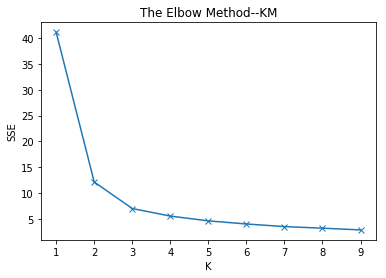

In [6]:
# sum of squared distances to closest cluster centers
clusters = range(1, 10)
wssse, result = find_km_metrics(X, clusters)

# Plot SSE for each *k*

plt.title('The Elbow Method--KM')
plt.xlabel('K'); 
plt.ylabel('SSE')
plt.xticks(clusters)
plt.plot(wssse.keys(), wssse.values(), 'x-')

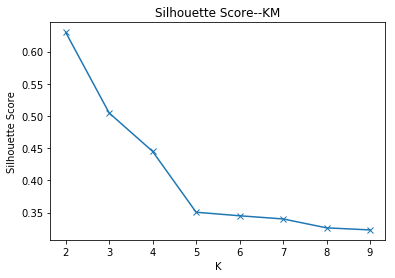

In [7]:
plt.title('Silhouette Score--KM')
plt.xlabel('K'); 
plt.ylabel('Silhouette Score')
plt.plot(result.keys(), result.values(), 'x-')

### GMM

In [8]:
def find_gmm_metrics(cotype, xtrain, clusters):

    result = {}
    bic = {}
    for t in cotype:
        for c in clusters:
            gmm = GaussianMixture(n_components=c, covariance_type=t, n_init=10, random_state=1)
            cluster_labels = gmm.fit_predict(xtrain)
            bic[(t, c)] = gmm.bic(xtrain)
            if c > 1:
                silhouette_avg = silhouette_score(xtrain, cluster_labels, random_state=1)
                result[(t, c)] = silhouette_avg
    return result, bic

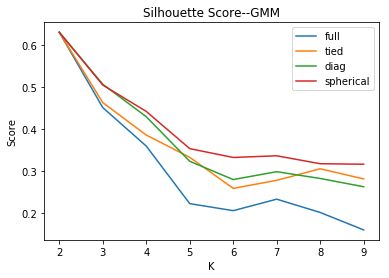

In [9]:
cotype = ['full', 'tied', 'diag', 'spherical']
result, bic = find_gmm_metrics(cotype, X, clusters)

plt.title('Silhouette Score--GMM')
plt.xlabel('K')
plt.ylabel('Score')
cotype = ['full', 'tied', 'diag', 'spherical']
for t in cotype:
    tmp = [result[k] for k in result if k[0]==t]
    xtick = [k[1] for k in result if k[0]==t]
    plt.plot(xtick, tmp, label=t)
    plt.legend()

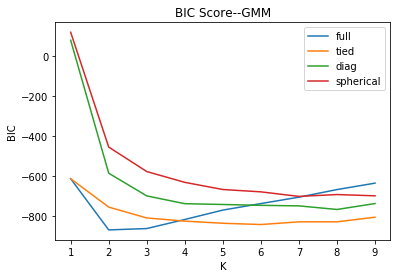

In [10]:
plt.title('BIC Score--GMM')
plt.xlabel('K')
plt.ylabel('BIC')
for t in cotype:
    tmp = [bic[k] for k in bic if k[0]==t]
    xtick = [k[1] for k in bic if k[0]==t]
    plt.plot(xtick, tmp, label=t)
    plt.legend()

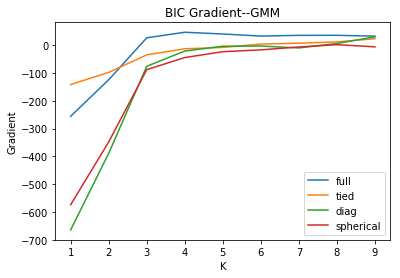

In [11]:
plt.title('BIC Gradient--GMM')
plt.xlabel('K')
plt.ylabel('Gradient')
for t in cotype:
    tmp = [bic[k] for k in bic if k[0]==t]
    xtick = [k[1] for k in bic if k[0]==t]
    plt.plot(xtick, np.gradient(tmp), label=t)
    plt.legend()

### Validate clusters

In [12]:
def find_adj_rand(modelname, xtrain, ytrain, clusters):
    result = {}
    
    if modelname == 'km':
        model = KMeans(random_state=1, n_jobs=-1)
    elif modelname == 'gmm':
        model = GaussianMixture(covariance_type='full', random_state=1, n_init=10)
    else:
        return "model unknown"

    for c in clusters:
        if modelname == 'km':
            model.set_params(n_clusters=c)
        else:
            model.set_params(n_components=c)

        cluster_labels = model.fit_predict(xtrain)
        score = adjusted_rand_score(ytrain, cluster_labels)
        result[c] = score

    return result

In [13]:
km_result = find_adj_rand('km', X, y, np.arange(2, 10))
km_result

{2: 0.5681159420289855,
 3: 0.7163421126838475,
 4: 0.6230929299814632,
 5: 0.4663500461988991,
 6: 0.45691137762247336,
 7: 0.4602735808588724,
 8: 0.424156661086247,
 9: 0.3903264126869283}

In [14]:
gmm_result = find_adj_rand('gmm', X, y, np.arange(2, 10))
gmm_result

{2: 0.5681159420289855,
 3: 0.9038742317748124,
 4: 0.8028146695161698,
 5: 0.6840118618371621,
 6: 0.5843624010976722,
 7: 0.48384021445696695,
 8: 0.4632012352032938,
 9: 0.42297184096913454}

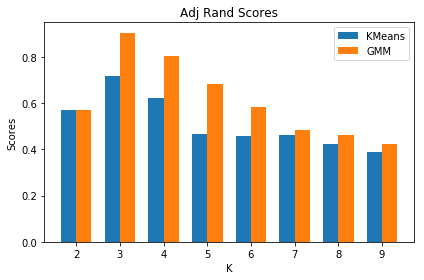

In [15]:
fig, ax = plt.subplots()

index = np.arange(2, 10)
bar_width = 0.35

bar1 = ax.bar(index, km_result.values(), bar_width, label='KMeans')
bar2 = ax.bar(index + bar_width, gmm_result.values(), bar_width, label='GMM')

ax.set_xlabel('K')
ax.set_ylabel('Scores')
ax.set_title('Adj Rand Scores')
ax.set_xticks(index + bar_width/2)
ax.set_xticklabels(index)
ax.legend()

fig.tight_layout()

### Visualize clusters

In [16]:
pca_viz = PCA(n_components=2, random_state=1)
X_viz = pca_viz.fit_transform(X)

In [17]:
pca_viz.explained_variance_ratio_

array([0.84136038, 0.11751808])

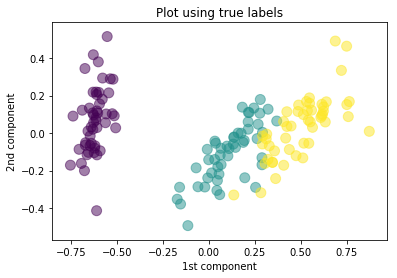

In [18]:
features = X_viz.T
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.set_title('Plot using true labels')
ax.scatter(features[0], features[1], c=y, alpha=0.5, s=100, cmap='viridis')

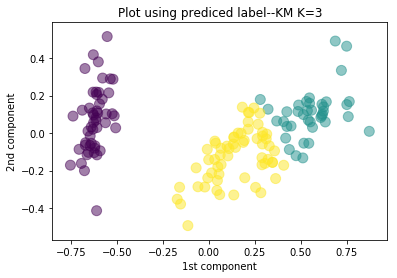

In [19]:
km = KMeans(n_clusters=3, random_state=1, n_jobs=-1)
labels = km.fit_predict(X_viz)

features = X_viz.T
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.set_title('Plot using prediced label--KM K=3')
ax.scatter(features[0], features[1], c=labels, alpha=0.5, s=100, cmap='viridis')

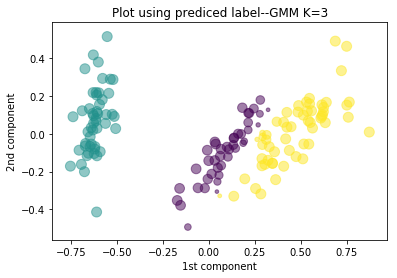

In [20]:
gmm = GaussianMixture(n_components=3, random_state=1, n_init=10)
labels = gmm.fit_predict(X_viz)
probs = gmm.predict_proba(X_viz)

features = X_viz.T
size = 100 * probs.max(1) ** 5
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.set_title('Plot using prediced label--GMM K=3')
ax.scatter(features[0], features[1], c=labels, alpha=0.5, s=size, cmap='viridis')

### Part2 Dimension Reduction

In [21]:
def find_var(dims, xtrain):
    result = {}
    for d in dims:
        pca = PCA(n_components=d, random_state=1)
        tmp = pca.fit_transform(xtrain)
        result[d] = sum(pca.explained_variance_ratio_)
    return result

In [22]:
dims = range(1, 5)
result = find_var(dims, X)
result

{1: 0.8413603821315431, 2: 0.9588784639918416, 3: 0.9936140780797742, 4: 1.0}

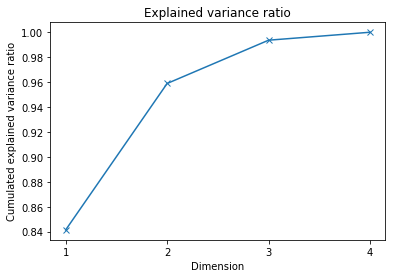

In [23]:
plt.title('Explained variance ratio')
plt.xticks(dims)
plt.xlabel('Dimension')
plt.ylabel('Cumulated explained variance ratio')
plt.plot(result.keys(), result.values(), 'x-')

In [24]:
def find_kurt(dims, xtrain):
    result = {}
    for d in dims:
        ica = FastICA(n_components=d, random_state=1)        
        tmp = ica.fit_transform(xtrain)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        result[d] = tmp.abs().mean()
    return result

In [25]:
result = find_kurt(dims, X)
result

{1: 1.4000015240092538,
 2: 0.9187300721813512,
 3: 0.6749760941474792,
 4: 0.8453691068579685}

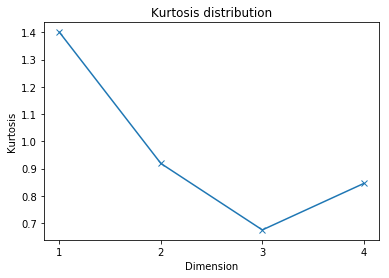

In [26]:
plt.title('Kurtosis distribution')
plt.xticks(dims)
plt.xlabel('Dimension')
plt.ylabel('Kurtosis')
plt.plot(result.keys(), result.values(), 'x-')

In [27]:
def reconstruction_error(dims, xtrain):
    result = {}
    for d in dims:
        srp = SparseRandomProjection(random_state=1, n_components=d)
        tmp = srp.fit_transform(xtrain)
        recon = np.dot(tmp, srp.components_.toarray())
        result[d] = np.mean((xtrain - recon)**2)
    return result

In [28]:
result = reconstruction_error(dims, X)
result

{1: 0.4388253536725824,
 2: 0.1926591875738134,
 3: 0.19069105914445814,
 4: 0.20932975154088243}

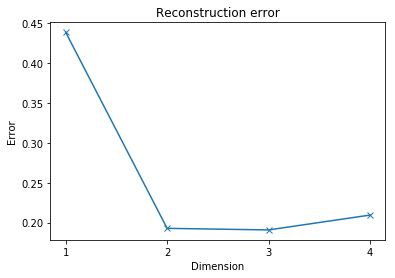

In [29]:
plt.title('Reconstruction error')
plt.xticks(dims)
plt.xlabel('Dimension')
plt.ylabel('Error')
plt.plot(result.keys(), result.values(), 'x-')

In [30]:
def find_lda_var(dims, xtrain, ytrain):
    result = {}
    for d in dims:
        lda = LinearDiscriminantAnalysis(n_components=d)
        tmp = lda.fit(xtrain, ytrain).transform(xtrain)
        result[d] = sum(lda.explained_variance_ratio_)
    return result

In [31]:
result = find_lda_var(dims, X, y)
result

{1: 0.9912126049653671,
 2: 0.9999999999999999,
 3: 0.9999999999999999,
 4: 0.9999999999999999}

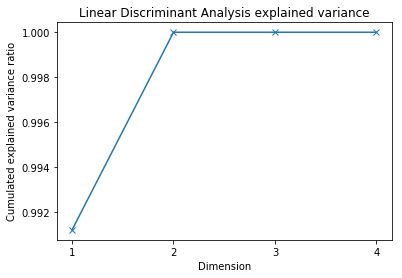

In [32]:
plt.title('Linear Discriminant Analysis explained variance')
plt.xticks(dims)
plt.xlabel('Dimension')
plt.ylabel('Cumulated explained variance ratio')
plt.plot(result.keys(), result.values(), 'x-')

### Part3 Redo clusering on dimension reduced data
    PCA:K=3  
    ICA:K=1  
    SRP:K=3  
    LDA:K=2

In [33]:
pca = PCA(n_components=3, random_state=1)
X_pca = pca.fit_transform(X)

ica = FastICA(n_components=1, random_state=1)
X_ica = ica.fit_transform(X)

srp = SparseRandomProjection(n_components=3, random_state=1)
X_srp = srp.fit_transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y)

### KMeans-PCA

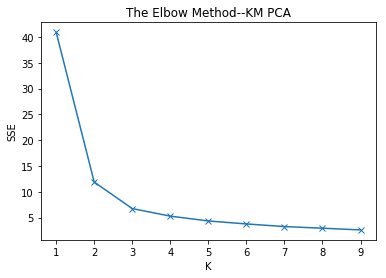

In [34]:
# sum of squared distances to closest cluster centers
clusters = range(1, 10)
wssse, result = find_km_metrics(X_pca, clusters)

# Plot SSE for each *k*

plt.title('The Elbow Method--KM PCA')
plt.xlabel('K'); 
plt.ylabel('SSE')
plt.xticks(clusters)
plt.plot(wssse.keys(), wssse.values(), 'x-')

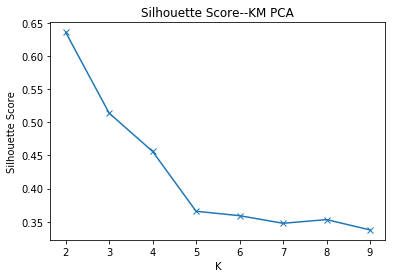

In [35]:
plt.title('Silhouette Score--KM PCA')
plt.xlabel('K'); 
plt.ylabel('Silhouette Score')
plt.plot(result.keys(), result.values(), 'x-')

### KMeans-ICA

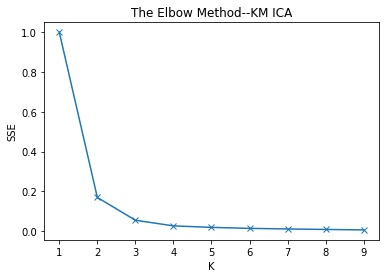

In [36]:
# sum of squared distances to closest cluster centers
wssse, result = find_km_metrics(X_ica, clusters)

# Plot SSE for each *k*

plt.title('The Elbow Method--KM ICA')
plt.xlabel('K'); 
plt.ylabel('SSE')
plt.xticks(clusters)
plt.plot(wssse.keys(), wssse.values(), 'x-')

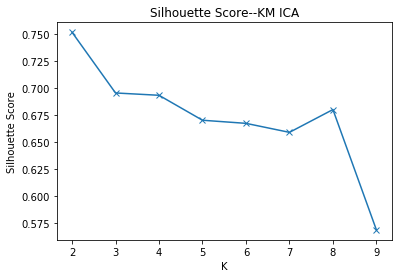

In [37]:
plt.title('Silhouette Score--KM ICA')
plt.xlabel('K'); 
plt.ylabel('Silhouette Score')
plt.plot(result.keys(), result.values(), 'x-')

### KMeans-SRP

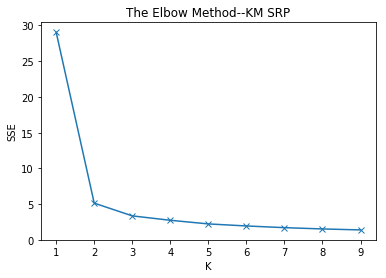

In [38]:
# sum of squared distances to closest cluster centers
wssse, result = find_km_metrics(X_srp, clusters)

# Plot SSE for each *k*

plt.title('The Elbow Method--KM SRP')
plt.xlabel('K'); 
plt.ylabel('SSE')
plt.xticks(clusters)
plt.plot(wssse.keys(), wssse.values(), 'x-')

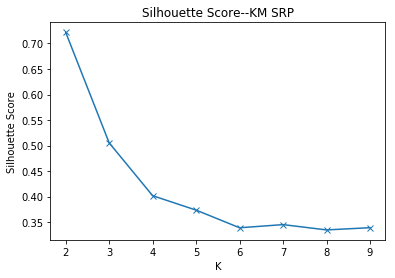

In [39]:
plt.title('Silhouette Score--KM SRP')
plt.xlabel('K'); 
plt.ylabel('Silhouette Score')
plt.plot(result.keys(), result.values(), 'x-')

### KMeans-LDA

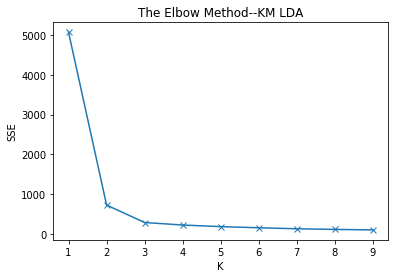

In [40]:
# sum of squared distances to closest cluster centers
wssse, result = find_km_metrics(X_lda, clusters)

# Plot SSE for each *k*

plt.title('The Elbow Method--KM LDA')
plt.xlabel('K'); 
plt.ylabel('SSE')
plt.xticks(clusters)
plt.plot(wssse.keys(), wssse.values(), 'x-')

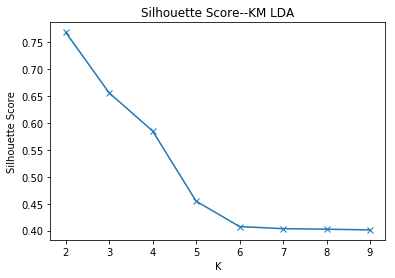

In [41]:
plt.title('Silhouette Score--KM LDA')
plt.xlabel('K'); 
plt.ylabel('Silhouette Score')
plt.plot(result.keys(), result.values(), 'x-')

### GMM-PCA

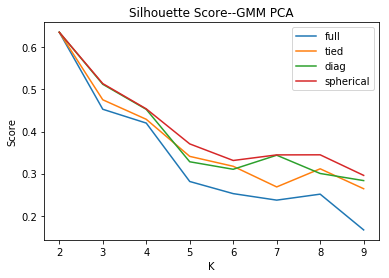

In [42]:
clusters = range(1, 10)
result, bic = find_gmm_metrics(cotype, X_pca, clusters)

plt.title('Silhouette Score--GMM PCA')
plt.xlabel('K')
plt.ylabel('Score')
cotype = ['full', 'tied', 'diag', 'spherical']
for t in cotype:
    tmp = [result[k] for k in result if k[0]==t]
    xtick = [k[1] for k in result if k[0]==t]
    plt.plot(xtick, tmp, label=t)
    plt.legend()

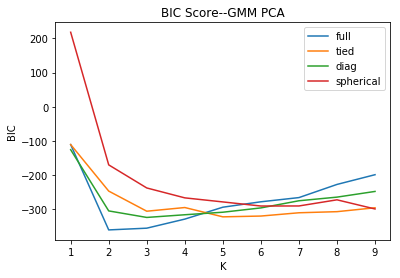

In [43]:
plt.title('BIC Score--GMM PCA')
plt.xlabel('K')
plt.ylabel('BIC')
for t in cotype:
    tmp = [bic[k] for k in bic if k[0]==t]
    xtick = [k[1] for k in bic if k[0]==t]
    plt.plot(xtick, tmp, label=t)
    plt.legend()

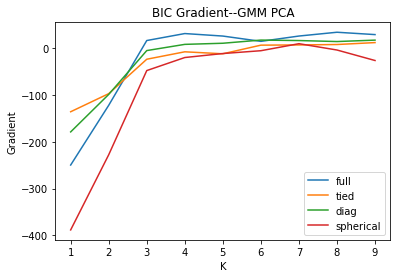

In [44]:
plt.title('BIC Gradient--GMM PCA')
plt.xlabel('K')
plt.ylabel('Gradient')
for t in cotype:
    tmp = [bic[k] for k in bic if k[0]==t]
    xtick = [k[1] for k in bic if k[0]==t]
    plt.plot(xtick, np.gradient(tmp), label=t)
    plt.legend()

### GMM-ICA

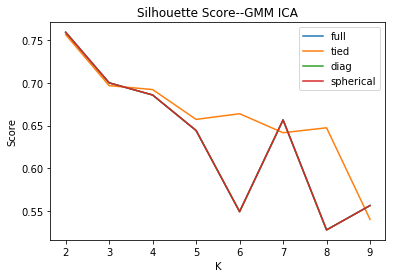

In [45]:
result, bic = find_gmm_metrics(cotype, X_ica, clusters)

plt.title('Silhouette Score--GMM ICA')
plt.xlabel('K')
plt.ylabel('Score')
cotype = ['full', 'tied', 'diag', 'spherical']
for t in cotype:
    tmp = [result[k] for k in result if k[0]==t]
    xtick = [k[1] for k in result if k[0]==t]
    plt.plot(xtick, tmp, label=t)
    plt.legend()

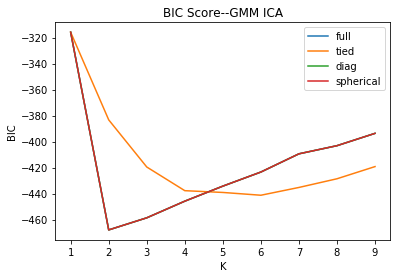

In [46]:
plt.title('BIC Score--GMM ICA')
plt.xlabel('K')
plt.ylabel('BIC')
for t in cotype:
    tmp = [bic[k] for k in bic if k[0]==t]
    xtick = [k[1] for k in bic if k[0]==t]
    plt.plot(xtick, tmp, label=t)
    plt.legend()

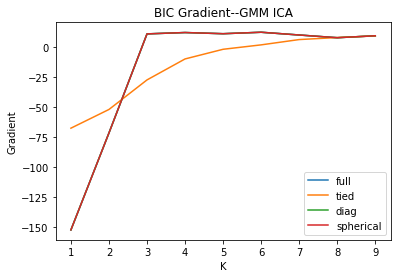

In [47]:
plt.title('BIC Gradient--GMM ICA')
plt.xlabel('K')
plt.ylabel('Gradient')
for t in cotype:
    tmp = [bic[k] for k in bic if k[0]==t]
    xtick = [k[1] for k in bic if k[0]==t]
    plt.plot(xtick, np.gradient(tmp), label=t)
    plt.legend()

### GMM-SRP

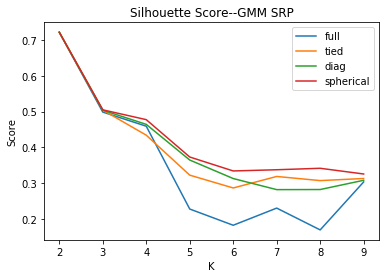

In [48]:
result, bic = find_gmm_metrics(cotype, X_srp, clusters)

plt.title('Silhouette Score--GMM SRP')
plt.xlabel('K')
plt.ylabel('Score')
cotype = ['full', 'tied', 'diag', 'spherical']
for t in cotype:
    tmp = [result[k] for k in result if k[0]==t]
    xtick = [k[1] for k in result if k[0]==t]
    plt.plot(xtick, tmp, label=t)
    plt.legend()

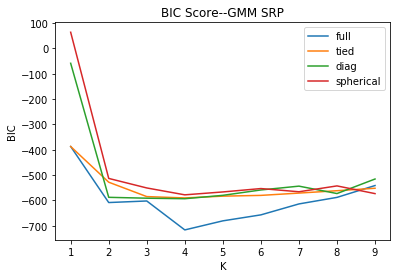

In [49]:
plt.title('BIC Score--GMM SRP')
plt.xlabel('K')
plt.ylabel('BIC')
for t in cotype:
    tmp = [bic[k] for k in bic if k[0]==t]
    xtick = [k[1] for k in bic if k[0]==t]
    plt.plot(xtick, tmp, label=t)
    plt.legend()

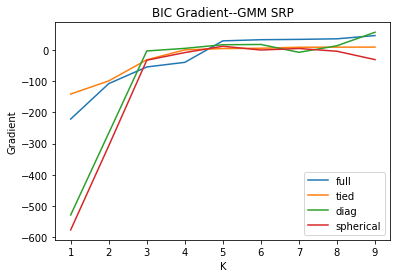

In [50]:
plt.title('BIC Gradient--GMM SRP')
plt.xlabel('K')
plt.ylabel('Gradient')
for t in cotype:
    tmp = [bic[k] for k in bic if k[0]==t]
    xtick = [k[1] for k in bic if k[0]==t]
    plt.plot(xtick, np.gradient(tmp), label=t)
    plt.legend()

### GMM-LDA

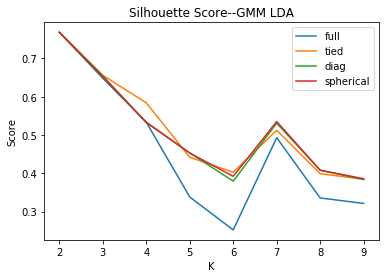

In [51]:
result, bic = find_gmm_metrics(cotype, X_lda, clusters)

plt.title('Silhouette Score--GMM LDA')
plt.xlabel('K')
plt.ylabel('Score')
cotype = ['full', 'tied', 'diag', 'spherical']
for t in cotype:
    tmp = [result[k] for k in result if k[0]==t]
    xtick = [k[1] for k in result if k[0]==t]
    plt.plot(xtick, tmp, label=t)
    plt.legend()

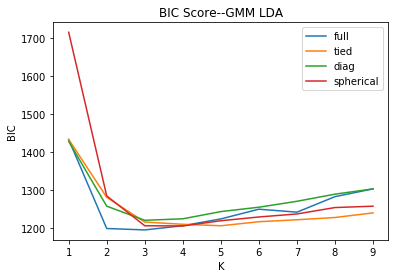

In [52]:
plt.title('BIC Score--GMM LDA')
plt.xlabel('K')
plt.ylabel('BIC')
for t in cotype:
    tmp = [bic[k] for k in bic if k[0]==t]
    xtick = [k[1] for k in bic if k[0]==t]
    plt.plot(xtick, tmp, label=t)
    plt.legend()

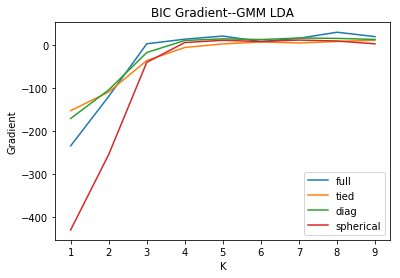

In [53]:
plt.title('BIC Gradient--GMM LDA')
plt.xlabel('K')
plt.ylabel('Gradient')
for t in cotype:
    tmp = [bic[k] for k in bic if k[0]==t]
    xtick = [k[1] for k in bic if k[0]==t]
    plt.plot(xtick, np.gradient(tmp), label=t)
    plt.legend()

### Validating Clusters

In [54]:
data = {'PCA':X_pca, 'ICA':X_ica, 'SRP':X_srp, 'LDA':X_lda}

km_result = {}
gmm_result = {}

for d in data:
    tmp1 = find_adj_rand('km', data[d], y, np.arange(2, 10))
    km_result[d] = tmp1
    tmp2 = find_adj_rand('gmm', data[d], y, np.arange(2, 10))
    gmm_result[d] = tmp2

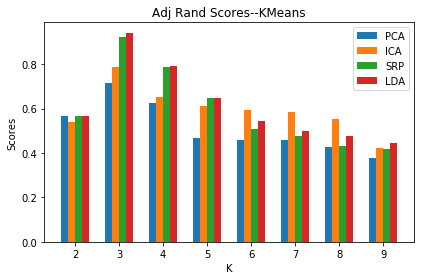

In [55]:
fig, ax = plt.subplots()

index = np.arange(2, 10)
bar_width = 0.16

bar1 = ax.bar(index, km_result['PCA'].values(), bar_width, label='PCA')
bar2 = ax.bar(index + bar_width, km_result['ICA'].values(), bar_width, label='ICA')
bar3 = ax.bar(index + 2*bar_width, km_result['SRP'].values(), bar_width, label='SRP')
bar4 = ax.bar(index + 3*bar_width, km_result['LDA'].values(), bar_width, label='LDA')

ax.set_xlabel('K')
ax.set_ylabel('Scores')
ax.set_title('Adj Rand Scores--KMeans')
ax.set_xticks(index + 3*bar_width/2)
ax.set_xticklabels(index)
ax.legend()

fig.tight_layout()

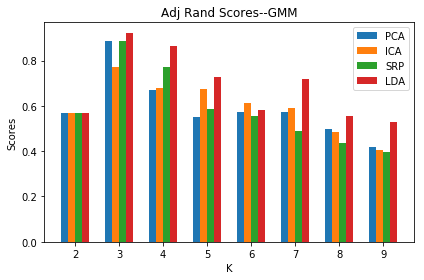

In [56]:
fig, ax = plt.subplots()

index = np.arange(2, 10)
bar_width = 0.16

bar1 = ax.bar(index, gmm_result['PCA'].values(), bar_width, label='PCA')
bar2 = ax.bar(index + bar_width, gmm_result['ICA'].values(), bar_width, label='ICA')
bar3 = ax.bar(index + 2*bar_width, gmm_result['SRP'].values(), bar_width, label='SRP')
bar4 = ax.bar(index + 3*bar_width, gmm_result['LDA'].values(), bar_width, label='LDA')

ax.set_xlabel('K')
ax.set_ylabel('Scores')
ax.set_title('Adj Rand Scores--GMM')
ax.set_xticks(index + 3*bar_width/2)
ax.set_xticklabels(index)
ax.legend()

fig.tight_layout()

### Visualizing Clusters K=3

In [57]:
data = [X_pca, X_ica, X_srp, X_lda]
label = ['PCA', 'ICA', 'SRP', 'LDA']
labels_km = {}
labels_gmm = {}
probs = {}

for i, d in enumerate(data):
    km = KMeans(n_clusters=3, random_state=1, n_jobs=-1)
    labels_km[label[i]] = km.fit_predict(d)
    
    gmm = GaussianMixture(n_components=3, random_state=1, n_init=10)
    labels_gmm[label[i]] = gmm.fit_predict(d)
    probs[label[i]] = gmm.predict_proba(d)

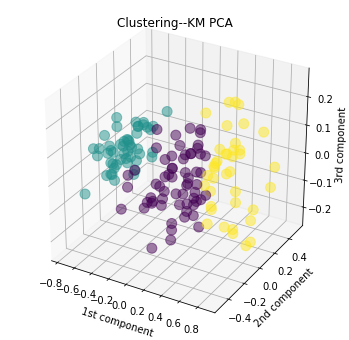

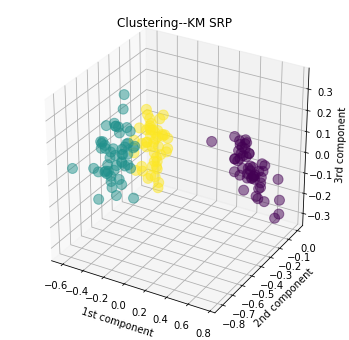

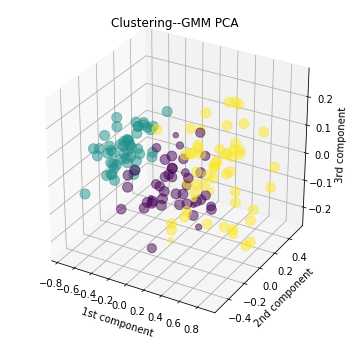

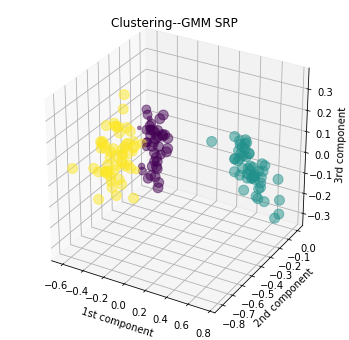

In [58]:
d = {'PCA':X_pca, 'SRP':X_srp}

for k in d:
    tmp = d[k].T
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('Clustering--KM '+k)
    ax.set_xlabel('1st component')
    ax.set_ylabel('2nd component')
    ax.set_zlabel('3rd component')
    ax.scatter(tmp[0], tmp[1], tmp[2], c=labels_km[k], s=100, alpha=0.5, cmap='viridis')

for k in d:
    tmp = d[k].T
    size = 100 * probs[k].max(1) ** 5
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('Clustering--GMM '+k)
    ax.set_xlabel('1st component')
    ax.set_ylabel('2nd component')
    ax.set_zlabel('3rd component')
    ax.scatter(tmp[0], tmp[1], tmp[2], c=labels_gmm[k], s=size, alpha=0.5, cmap='viridis')

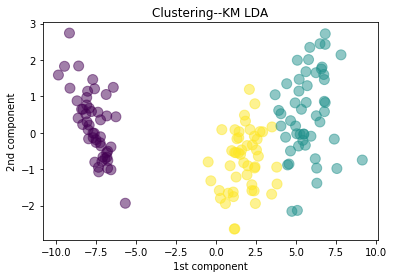

In [59]:
plt.title('Clustering--KM LDA')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.scatter(X_lda.T[0], X_lda.T[1], c=labels_km['LDA'], s=100, alpha=0.5, cmap='viridis')

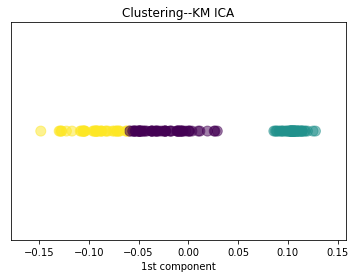

In [60]:
plt.title('Clustering--KM ICA')
plt.xlabel('1st component')
plt.yticks([])
plt.scatter(X_ica.T[0], np.zeros_like(X_ica.T[0])+0, c=labels_km['ICA'], s=100, alpha=0.5, cmap='viridis')

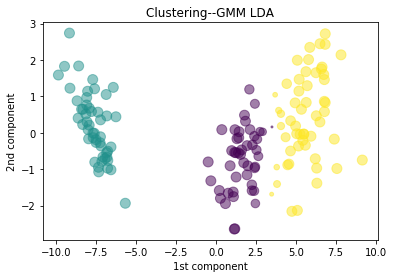

In [61]:
size = 100 * probs['LDA'].max(1) ** 5
plt.title('Clustering--GMM LDA')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.scatter(X_lda.T[0], X_lda.T[1], c=labels_gmm['LDA'], s=size, alpha=0.5, cmap='viridis')

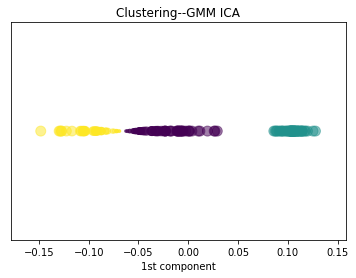

In [62]:
size = 100 * probs['ICA'].max(1) ** 5
plt.title('Clustering--GMM ICA')
plt.xlabel('1st component')
plt.yticks([])
plt.scatter(X_ica.T[0], np.zeros_like(X_ica.T[0])+0, c=labels_gmm['ICA'], s=size, alpha=0.5, cmap='viridis')